In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import timeit

from scipy.spatial import KDTree

from platform import python_version
print(python_version())

3.9.9


In [57]:
# set parameters
dt = 1/20 # 20 hz or 0.2 seconds
v_x_c = 1.5 # m/s
horizon = 0.75 # s
n_steps = int(horizon / dt)
n_samples = 1000
std_dev_cmd = 1.5 # rad/s

print(n_steps)

15


In [58]:
## create ref traj

df = pd.read_csv('../data/boreal_smooth.csv', header=None)
# xs = df['Points:1']
xs = df[0]
# ys = df['Points:0']
ys = df[1]
    
ref_traj = np.array([[x,y] for x,y in zip(xs,ys)])
# print(ref_traj)

# create kdtree from traj
ref_tree = KDTree(ref_traj)
# print(ref_traj)

In [59]:
# useful functions

def update_R(R, theta):
    R[0,0] = R[1,1] = np.cos(theta)
    sin_theta = np.sin(theta)
    R[0,1] = -sin_theta
    R[1,0] = sin_theta
    return R

def sample_trajs(u_nom, x_init, n_samples, n_steps, std_dev_cmd, min_cost):
    
    R_init = np.eye(3)
    pool = []
    cost_list = []
    min_cost_traj = -1
    
    for j in range(0, n_samples):
        u_std_dev = np.random.normal(loc=0.0, scale = std_dev_cmd, size=(1, n_steps))
        u_s = copy.deepcopy(u_nom)
        u_s[2, :] = u_s[2, :] + u_std_dev

        traj = []

        curr_x = x_init

        for i in range(0, n_steps):
            R = update_R(R_init, curr_x[2])
            dx = u_s[:, i]
            new_x = R.T @ dx * dt + curr_x
#             cost = cost + dd
            traj.append(new_x)
            curr_x = new_x

        traj = np.transpose(np.asarray(traj))
        pool.append(traj)
        
        dd, _ = ref_tree.query(traj[:2, :].T, k=1, workers=-1)
        cost = np.sum(dd)
        
        if j > min_cost_traj and cost < min_cost:
            min_cost_traj = j
            min_cost = cost
    return pool, min_cost_traj, cost

In [72]:
# initialize state

x_init = np.array([0.0, 0.0, 0.0])
curr_x = x_init

u_nom = np.zeros((3, n_steps))
u_nom[0, :] = v_x_c
u_nom[2, :] = -np.pi/2

traj_nom = []

R_init = np.eye(3)

for i in range(0, n_steps):
    nom_cost = 0
    R = update_R(R_init, curr_x[2])
    dx = u_nom[:, i]
    new_x = R.T @ dx * dt + curr_x
    traj_nom.append(new_x)
    curr_x = new_x
traj_nom = np.transpose(np.asarray(traj_nom))
dd, _ = ref_tree.query(traj_nom[:2, :].T, k=1, workers=-1)
nom_cost = np.sum(dd)

%timeit sample_trajs(u_nom, x_init, n_samples, n_steps, std_dev_cmd, nom_cost)
pool, min_cost_traj, cost = sample_trajs(u_nom, x_init, n_samples, n_steps, std_dev_cmd, nom_cost)
    
# print(pool)

1.18 s ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
print(min_cost_traj)
print(cost)

812
3.6966777434520024


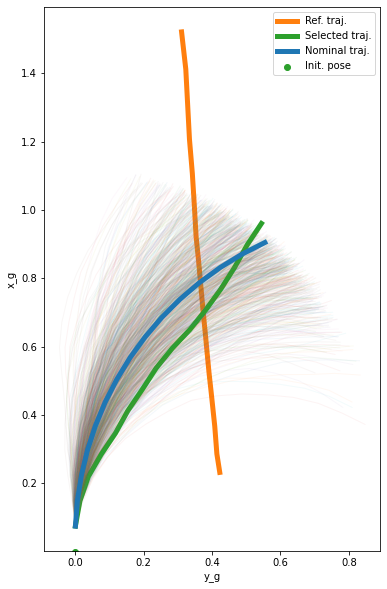

In [79]:
# plot traj

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(ref_traj[:15, 1], ref_traj[:15, 0], c='C1', linewidth=5, label='Ref. traj.')

for i in range(0, n_samples):
    if i == min_cost_traj:
        ax.plot(pool[i][1, :], pool[i][0, :], linewidth=5, label='Selected traj.')
    else:
        ax.plot(pool[i][1, :], pool[i][0, :], linewidth=1, alpha = 0.05)
    
ax.plot(traj_nom[1, :], traj_nom[0, :], linewidth=5, c='C0', label='Nominal traj.')
ax.scatter(x_init[1], x_init[0], c='C2', label='Init. pose')

ax.set_aspect('equal')
ax.set_xlabel('y_g')
ax.set_ylabel('x_g')
ax.legend()
